In [1]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import cmath

# Zadanie 1

In [2]:
def find1(image_matrix, pattern_matrix, precision):

    C = np.real(np.fft.ifft2(np.multiply(np.fft.fft2(image_matrix), np.fft.fft2(np.rot90(pattern_matrix, 2), s=image_matrix.shape))))

    plt.figure(figsize=(20,10))
    plt.imshow(image_matrix, cmap='gray')
    plt.show()

    plt.figure(figsize=(20,10))
    plt.imshow(pattern_matrix, cmap='gray')
    plt.show()

    res = (np.where(C > precision * C.max()))
    coord = list(zip(res[0], res[1]))
    
    coord_copy = [None for _ in range(len(coord))]
    
    
    for i, c1 in enumerate(coord):
        coord_copy[i] = c1
    
    for i in range(len(coord_copy)):
        if coord_copy[i] is None:
            continue
        for j in range(i+1, len(coord_copy)):
            if coord_copy[j] is None:
                continue
            if abs(coord_copy[i][0] - coord_copy[j][0]) < pattern_matrix.shape[0] and abs(coord_copy[i][1] - coord_copy[j][1]) < pattern_matrix.shape[1]:
                coord_copy[j] = None

    out = np.zeros(image_matrix.shape)
    for i, j in coord:
        out[i-pattern_matrix.shape[0]:i, j-pattern_matrix.shape[1]:j] = 255

    out = 0.5 * out + image_matrix;

    plt.figure(figsize=(20,10))
    plt.imshow(out, cmap='gray')
    plt.show()
    
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.gca(projection='3d')

    X = np.arange(0, C.shape[1])
    Y = np.arange(0, C.shape[0])
    X, Y = np.meshgrid(X, Y)

    ax.plot_surface(X, Y, C, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.view_init(20, -20)
    plt.show()
    
    ph = np.zeros(C.shape)
    mod = np.zeros(C.shape)
    
    for i, row in enumerate(C):
        for j, x in enumerate(row):
            mod[i][j] = abs(C[i][j])
            ph[i][j] = cmath.phase(C[i][j])
            
    fig = plt.figure(figsize=(20,20))
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, mod, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.view_init(20, -20)
    plt.show()
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, ph, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.view_init(20, -20)
    plt.show()
    
    
    occurences_number = 0
    for i in coord_copy:
        if i is not None:
            occurences_number += 1
    print('Liczba wystąpień wzorca: ', occurences_number)

Poniżej przedstawiono uzyskane wyniki dla teksu oraz obrazka z ławicą ryb. Dla tekstu minimalny stosunek wartośći korelacji dopasowania wzorca do maksymalnej wielkości wynosi 0.9, dla ławicy ryb jest to 0.7

Pierwsze trzy obrazki przedstawiaja kolejno: oryginalny obraz, wzorzec oraz obraz z dopasowanym wzorcem.

Następnie przedstawiono trzy wykresy: wartość korelacji między obrazem a wzorcem, wartość

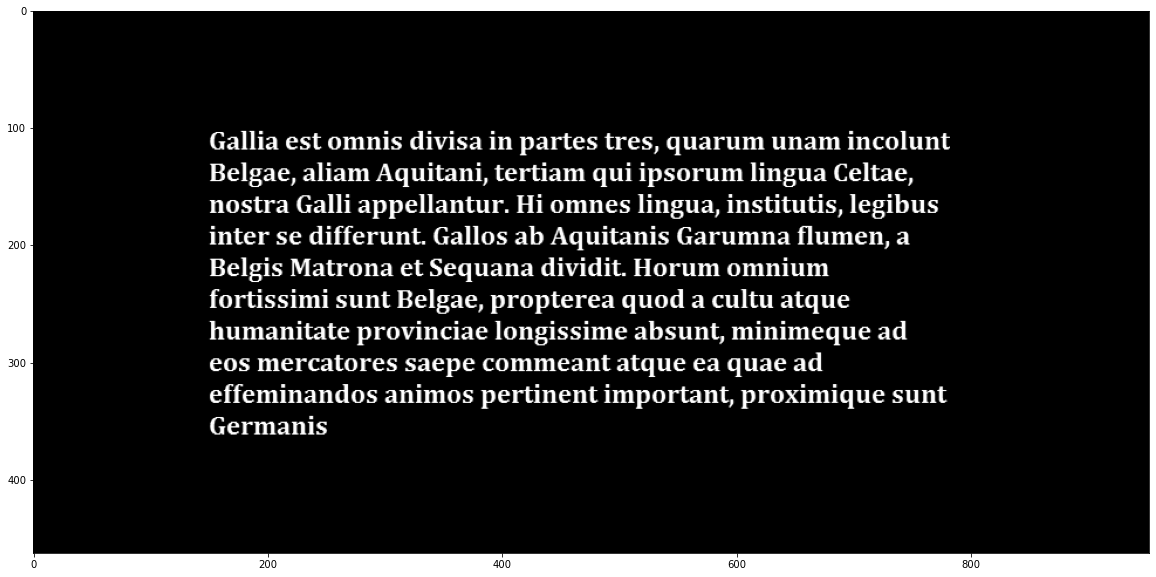

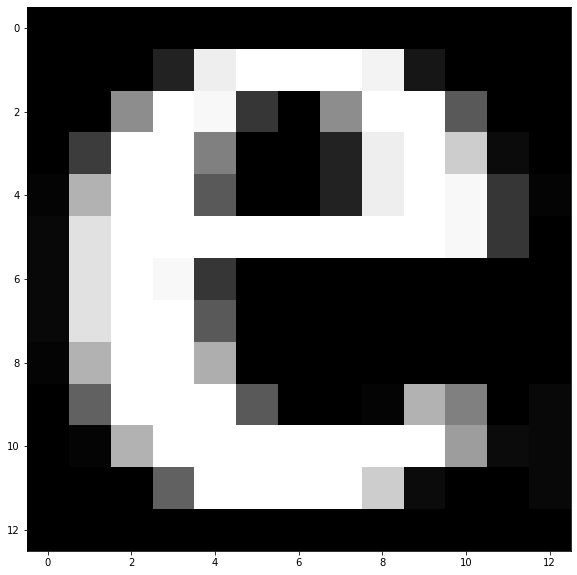

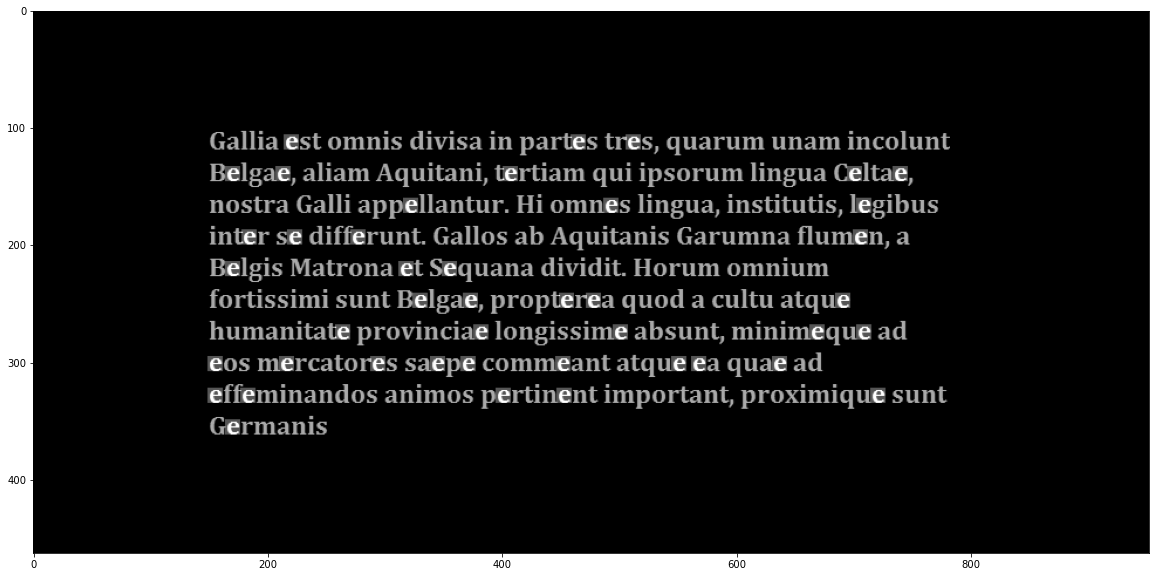

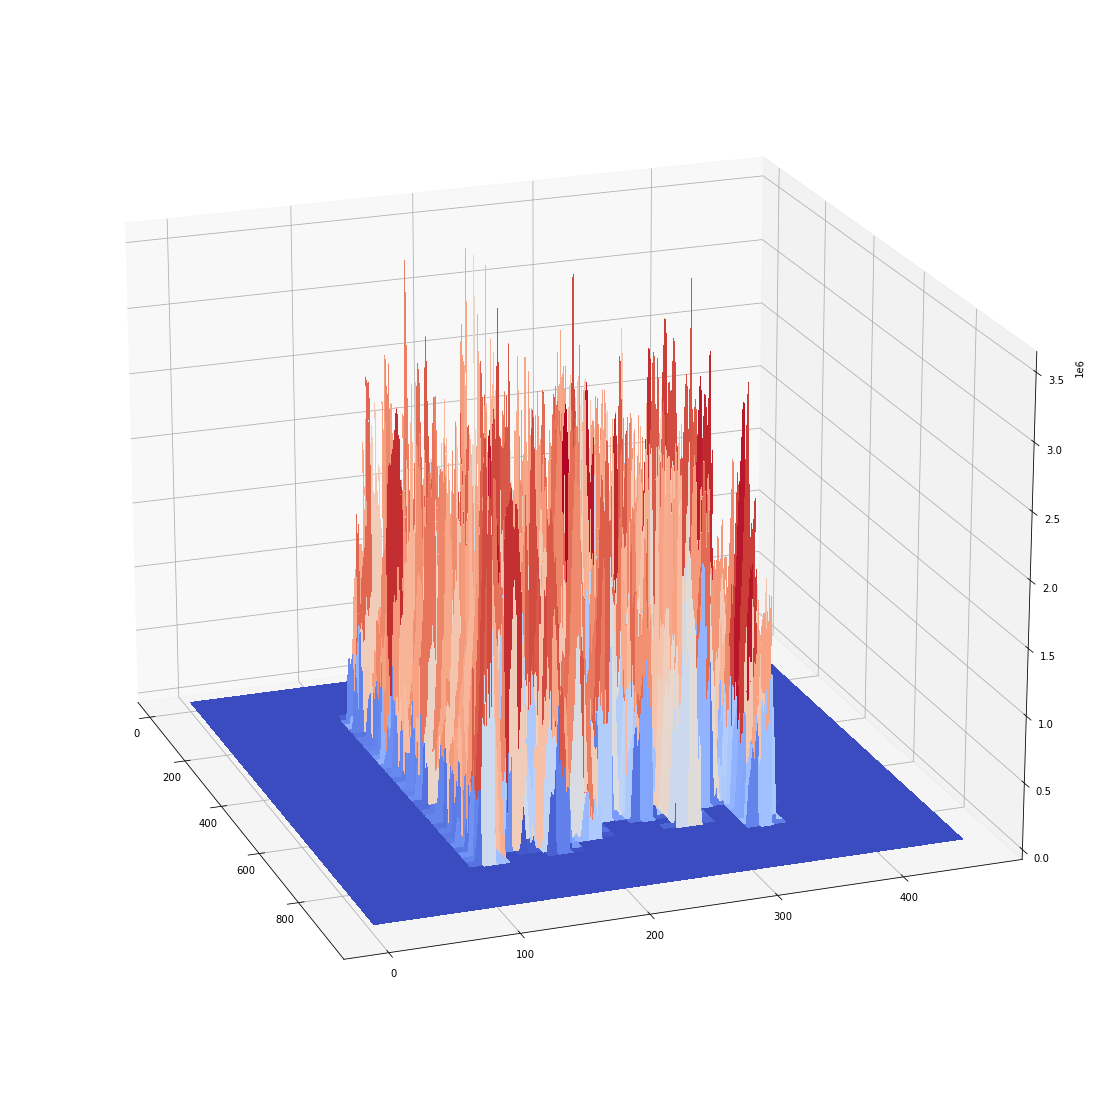

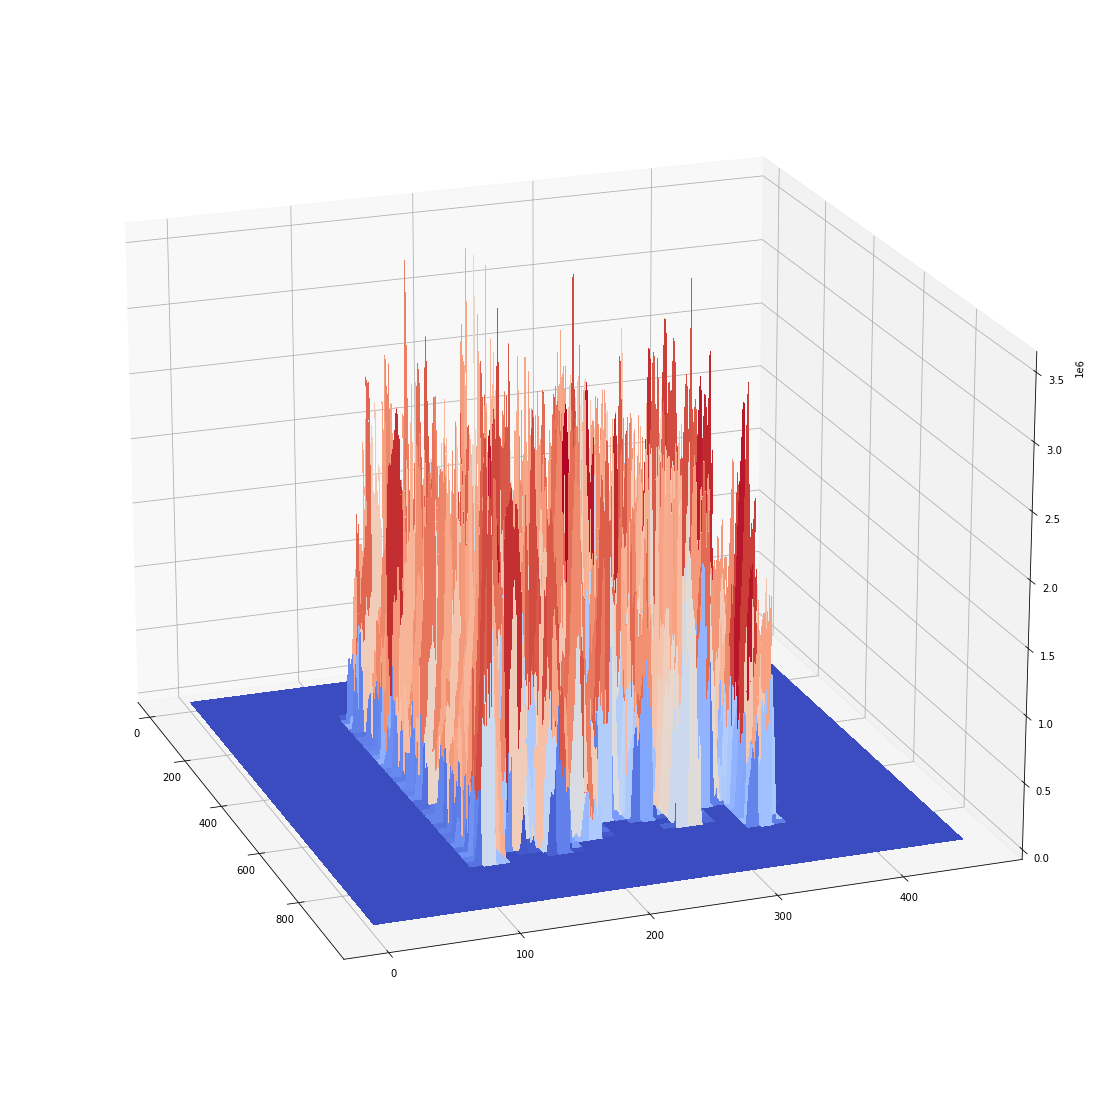

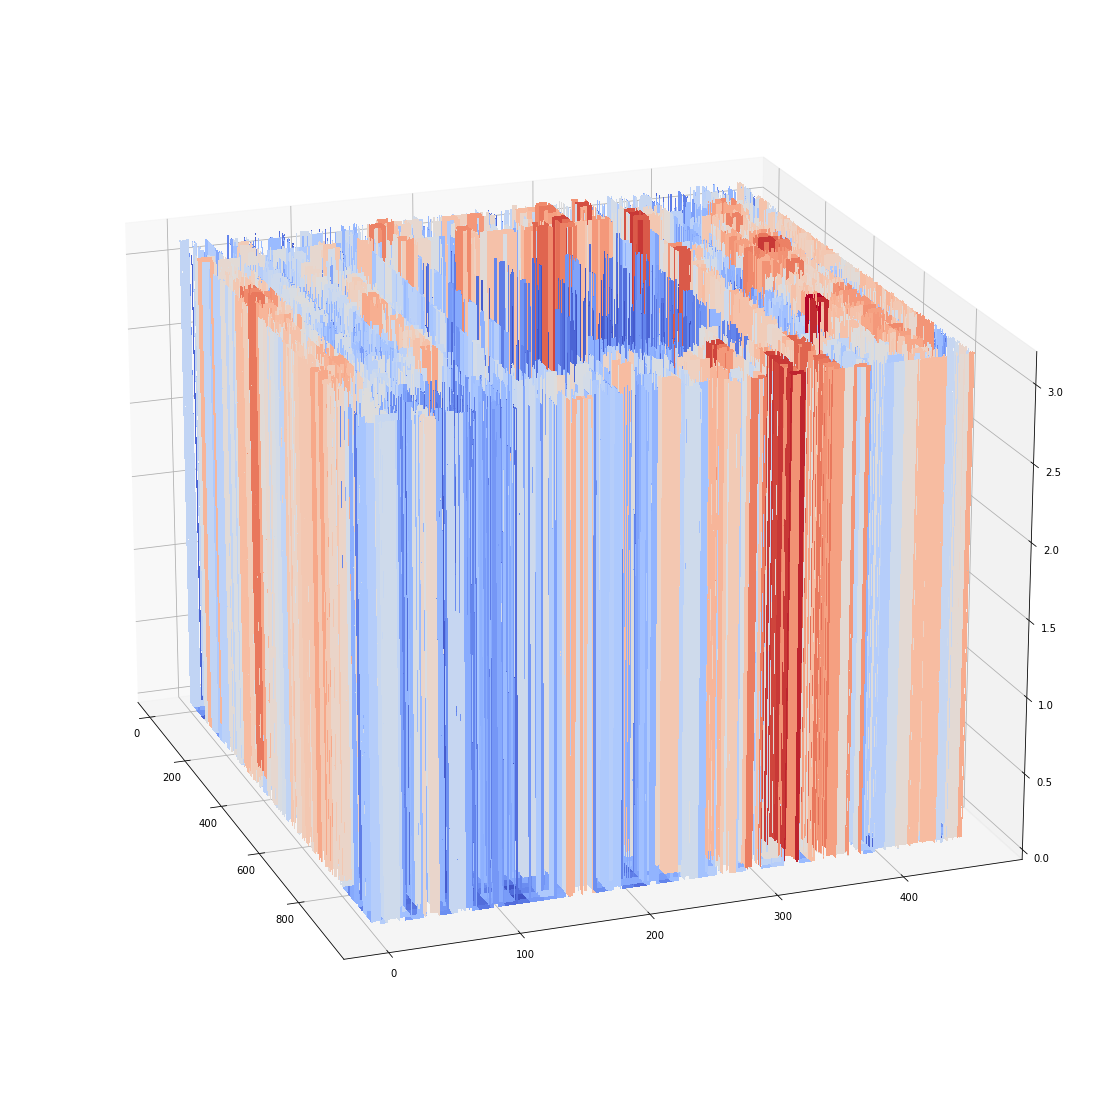

Liczba wystąpień wzorca:  43


In [3]:
orginal_image = Image.open('galia.png').convert("L")
image_matrix = 255 - np.array(orginal_image)

pattern = Image.open('galia_e.png').convert("L")
pattern_matrix = 255 - np.array(pattern)

find1(image_matrix, pattern_matrix, 0.9)

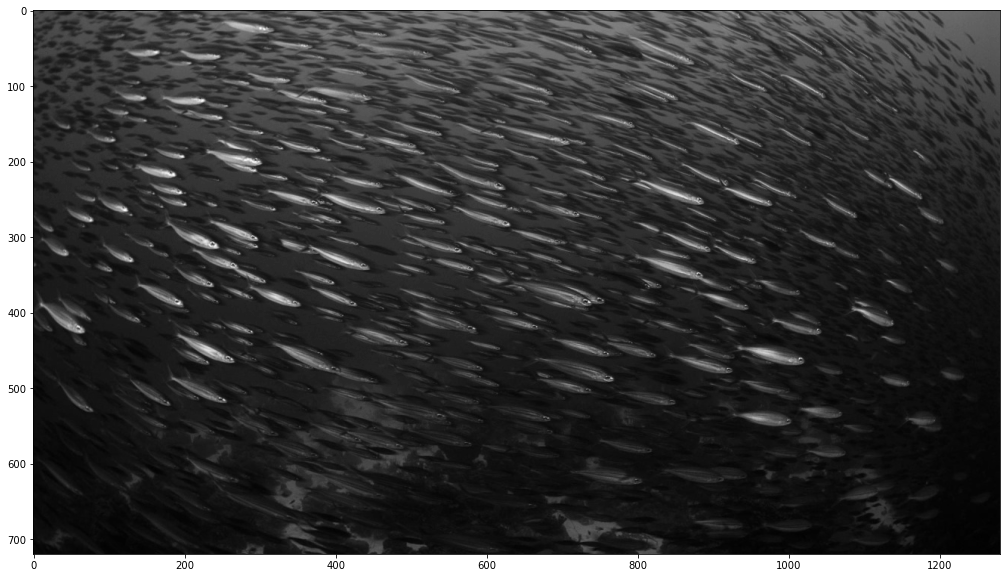

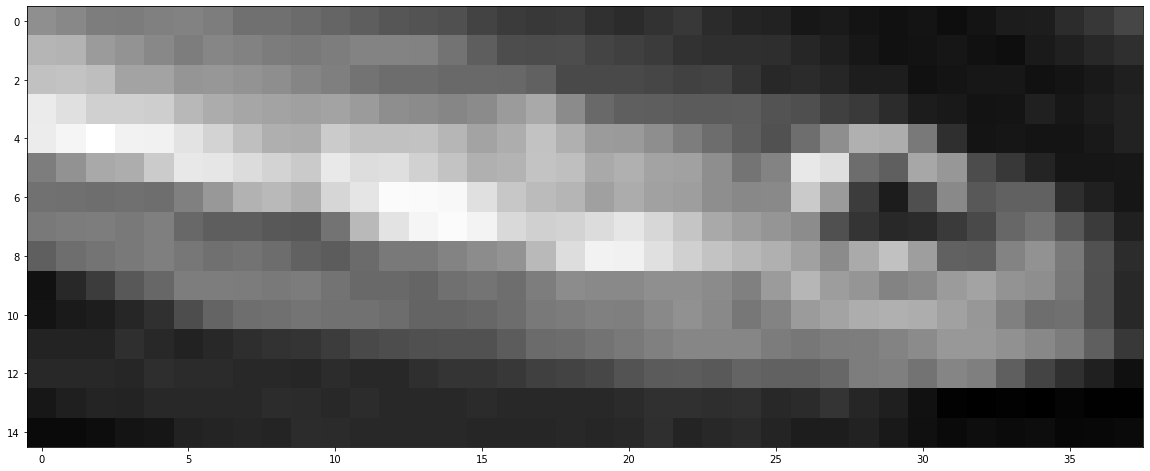

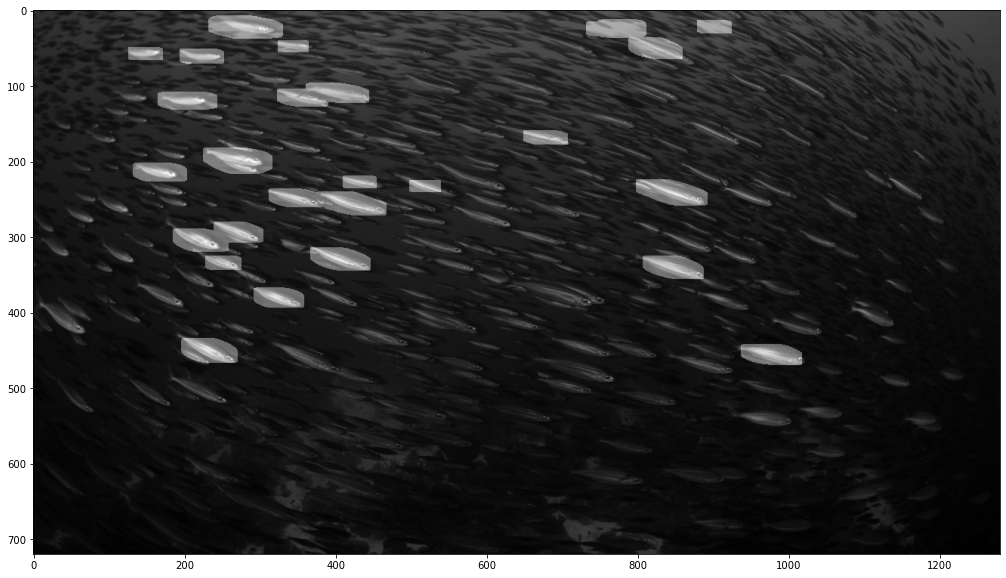

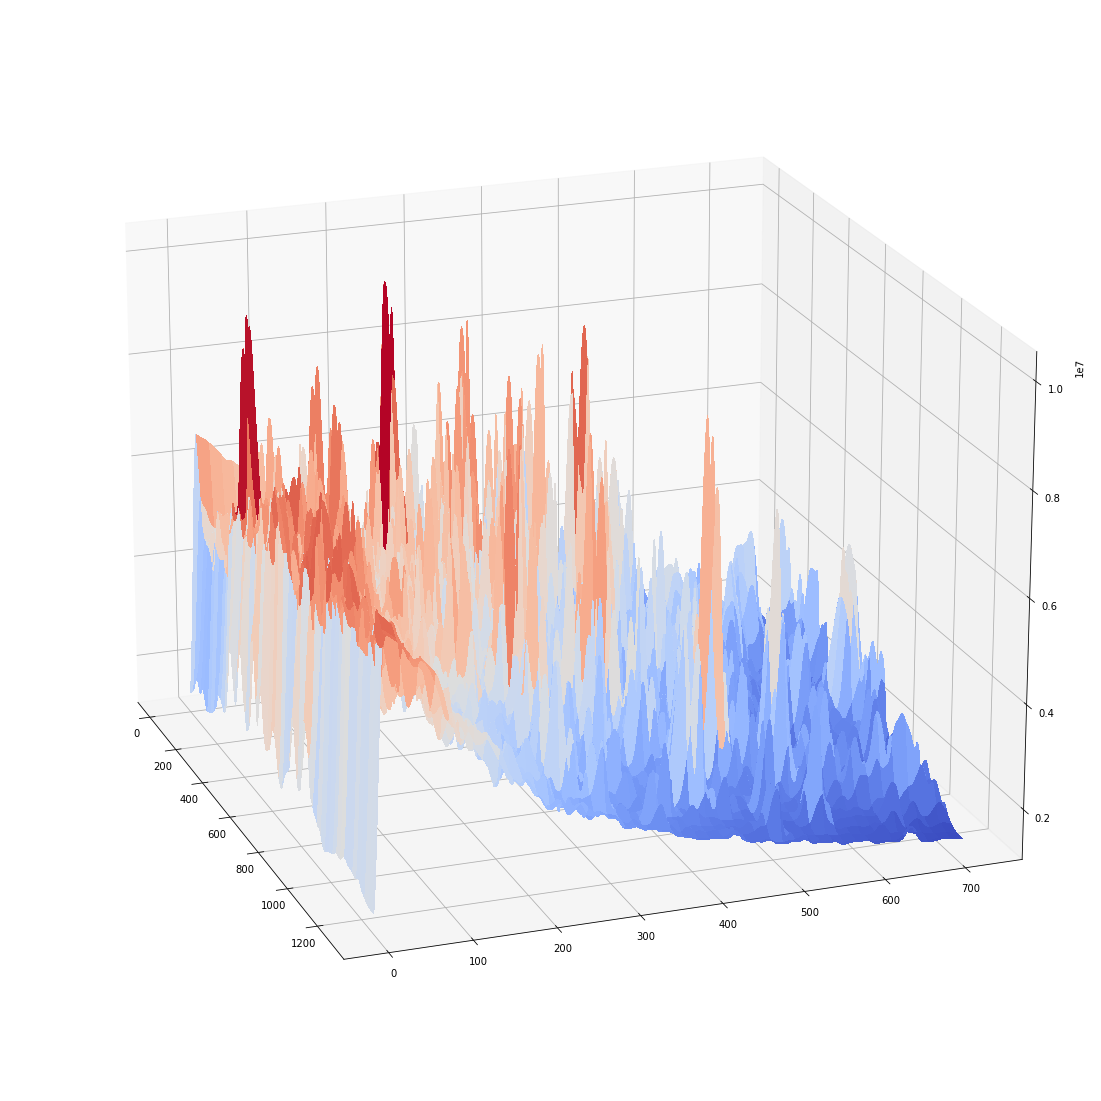

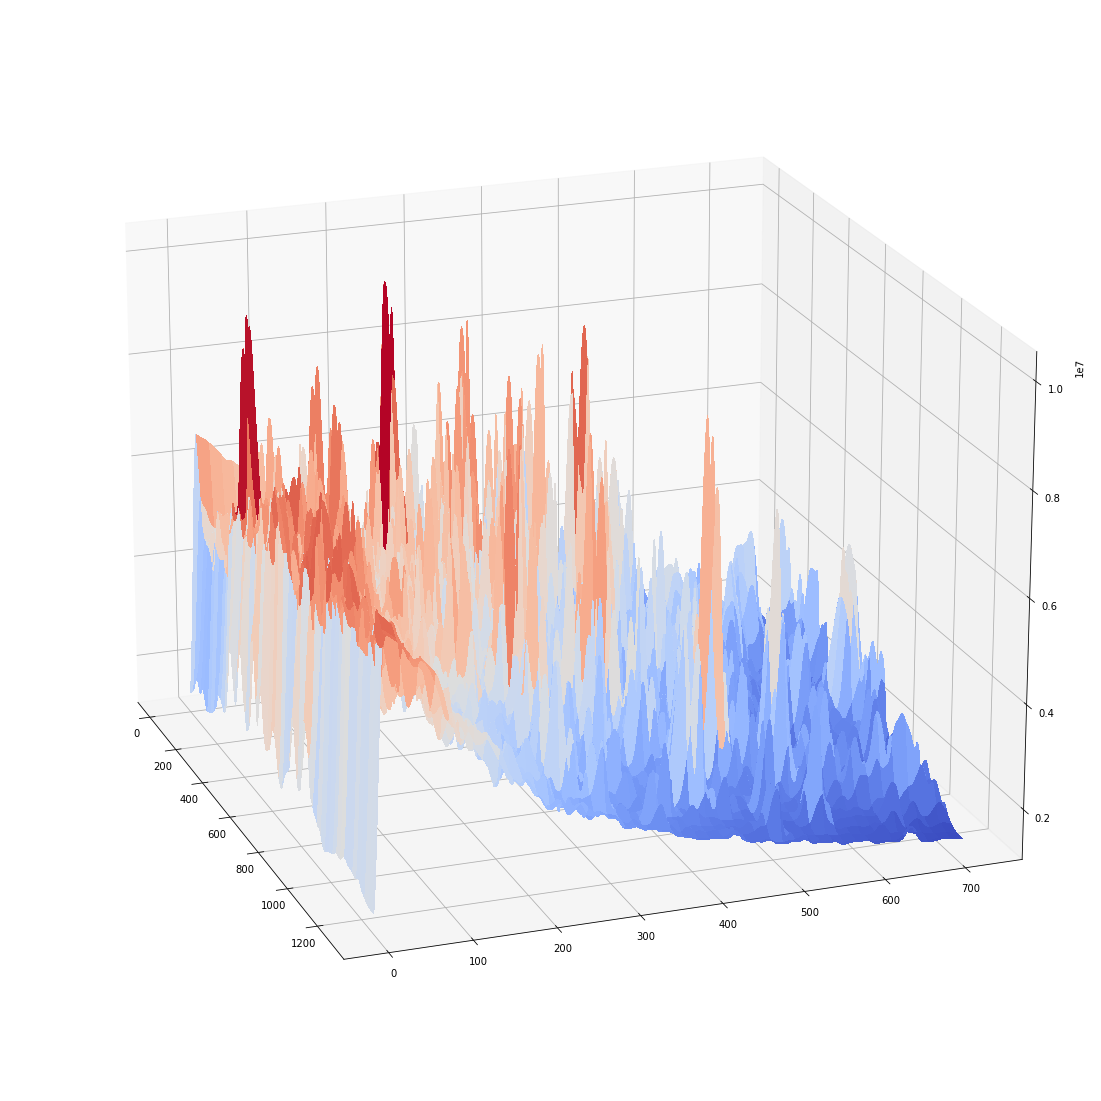

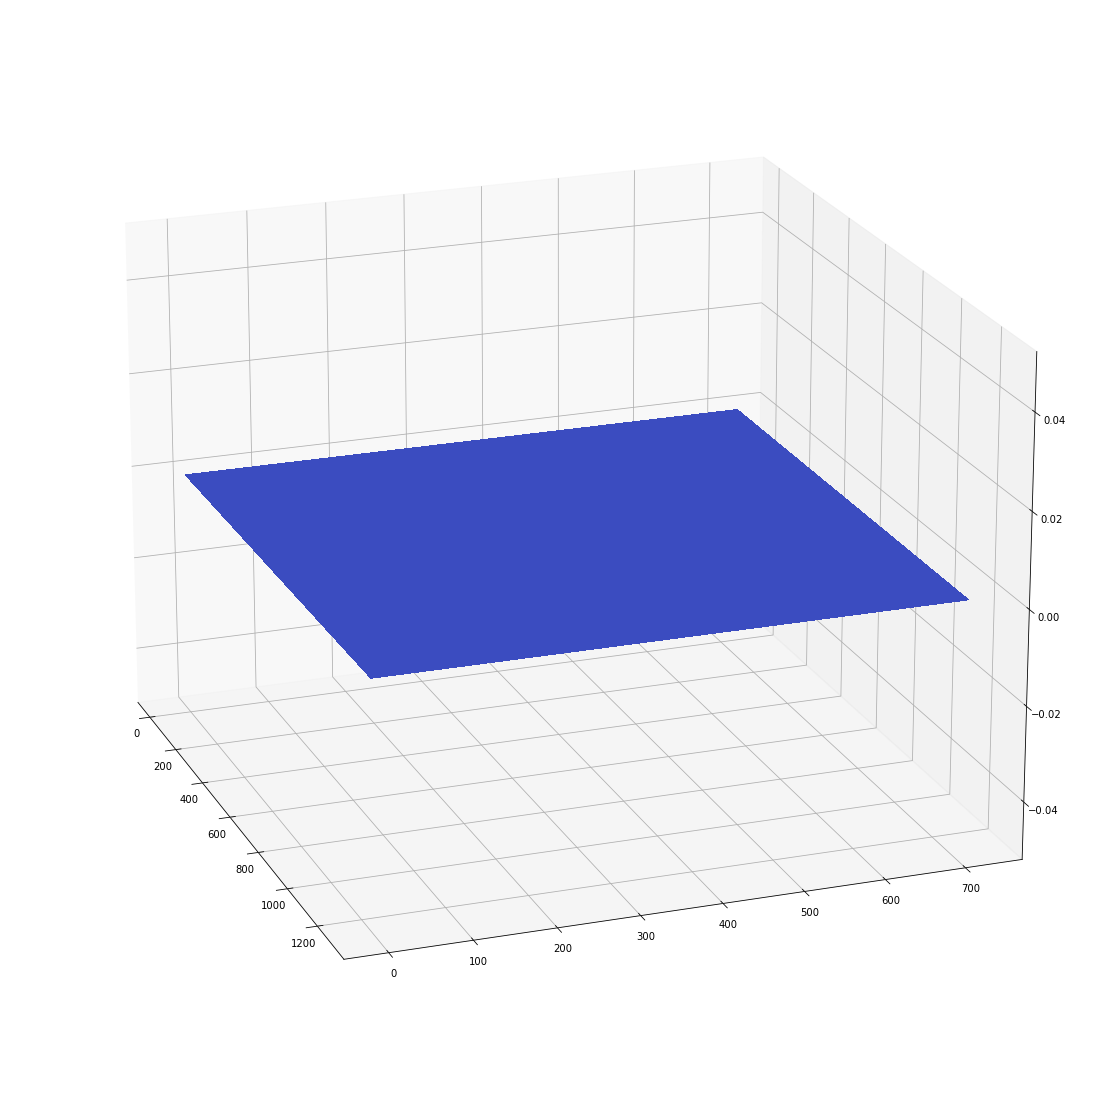

Liczba wystąpień wzorca:  39


In [4]:
orginal_image = Image.open('school.jpg').convert("L")
image_matrix = np.array(orginal_image)

pattern = Image.open('fish1.png').convert("L")
pattern_matrix = np.array(pattern)

find1(image_matrix, pattern_matrix, 0.7)

# Zadanie 2

OCR działa w oparciu o korelację obliczaną przy pomocy DFT. Obraz wejściowy został przekształcony przy pomocy SVD w celu usunięcia szumów. Przy pomocy DFT wykrywany jest także obrót obrazu.

Funkcja zwracająca wzorzec danej litery o zadanym rozmiarze:

In [5]:
def get_character_pattern(character, line_height, font_path):
    font_size = int(line_height)
    img = Image.new('L', (2 * font_size, 2 * font_size), color=0)

    fnt = ImageFont.truetype(font_path, font_size)
    d = ImageDraw.Draw(img)
    d.text((10, 10), character, font=fnt, fill=255)

    bounds = np.where(np.array(img) != 0)
    img = img.crop((min(bounds[1]), min(bounds[0]), max(bounds[1]), max(bounds[0])))
    return np.array(img)

Funkcja do odczytu pliku z obrazem, odwraca kolory

In [6]:
def get_image_from_file(image_name):
    return 255 - np.array(Image.open(image_name).convert("L"))

Funkcja do redukcji szumów przy pomocy SVD

In [7]:
def reduce_image(image):
    U, s, Vt = np.linalg.svd(image)

    k = int(0.9 * len(s))
    image2 = np.zeros(image.shape)
    for i in range(k):
        image2 = image2 + s[i] * np.outer(np.transpose(U)[i], Vt[i])

    return image2

Funkcja odnajdująca wzorzec na obrazku przy pomocy DFT

In [8]:
def find(image_matrix, pattern_matrix):
    C = np.real(np.fft.ifft2(
        np.multiply(np.fft.fft2(image_matrix), np.fft.fft2(np.rot90(pattern_matrix, 2), s=image_matrix.shape))))

    max_value = np.amax(C)

    where = np.where(C == max_value)

    return max_value, np.array([where[0][0], where[1][0]])

Funkcja dzieląca obraz na części

In [9]:
def split_image(image_matrix, space):
    lines = []
    lines_edges = []
    empty_lines_no = 0
    space_start = None

    for row in image_matrix:
        lines.append(np.count_nonzero(row))

    lines_number = 0
    lines_height = []
    in_line = False
    for index, line in enumerate(lines):
        if line > 0:
            empty_lines_no = 0
            space_start = None
            if not in_line:
                lines_number += 1
                lines_height.append(0)
                lines_edges.append([index, index])
            lines_height[lines_number - 1] += 1
            in_line = True
        if line <= 0:
            empty_lines_no += 1
            if space_start is None:
                space_start = index
        if empty_lines_no >= space + 1 and in_line:
            in_line = False
            lines_edges[lines_number - 1][1] = space_start

    return np.average(lines_height), lines_edges

Funkcja wykrywająca obrót obrazu

In [10]:
def get_rotation(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift))

    def transform_data(m):
        dpix, dpiy = m.shape
        x_c, y_c = np.unravel_index(np.argmax(m), m.shape)
        angles = np.linspace(0, np.pi * 2, min(dpix, dpiy))
        mrc = min(abs(x_c - dpix), abs(y_c - dpiy), x_c, y_c)
        radiuses = np.linspace(0, mrc, max(dpix, dpiy))
        A, R = np.meshgrid(angles, radiuses)
        X = R * np.cos(A)
        Y = R * np.sin(A)
        return A, R, m[X.astype(int) + mrc - 1, Y.astype(int) + mrc - 1]

    angles, radiuses, m = transform_data(magnitude_spectrum)

    sample_angles = np.linspace(0, 2 * np.pi, len(m.sum(axis=0))) / np.pi * 180
    turn_angle_in_degrees = 180 - sample_angles[np.argmax(m.sum(axis=0))]
    
    multipliers = [-3,-2,-1,1,2,3]
    
    for mul in multipliers:
        tmp = 90 * mul + turn_angle_in_degrees
        if abs(tmp) < 45:
            turn_angle_in_degrees = tmp
            break

    return turn_angle_in_degrees

Główna funkcja do rozpoznawania tekstu

In [11]:
def ocr(image_matrix, font_size, font_path):
    lines_height = font_size

    text = ''
    letters = 'abcdefghijklmnopqrstuvwxyz0123456789.,?!'

    occurrences_number = {}

    for l in letters:
        occurrences_number[l] = 0

    patterns = []

    for letter in letters:
        patterns.append(get_character_pattern(letter, lines_height, font_path))

    pattern_match_level = []
    pattern_center = []

    for pattern in patterns:
        level, place = find(pattern, pattern)
        pattern_match_level.append(level)
        pattern_center.append(place)

    img = Image.fromarray(image_matrix, 'L')
    rot = get_rotation(img)

    if abs(rot) > 0.5:
        plt.figure(figsize=(20, 10))
        plt.imshow(image_matrix, cmap='gray')
        plt.show()
        
        image_matrix = np.array(img.rotate(rot))
        
    image_matrix = np.array(reduce_image(image_matrix), dtype=int)
    
    plt.figure(figsize=(20, 10))
    plt.imshow(image_matrix, cmap='gray')
    plt.show()

    lines_edges = split_image(image_matrix, 0)[1]

    for edges in lines_edges:
        all_letters_matrix.append([])
        line_matrix = image_matrix[edges[0]:edges[1], 0:image_matrix.shape[1]]

        word_height, word_edges = split_image(line_matrix.T, int(lines_height / 6))

        for edges2 in word_edges:
            word_matrix = image_matrix[edges[0] - 1:edges[1] + 1, edges2[0] - 1:edges2[1] + 1]

            word_matrix = np.where(word_matrix < 150, 0, word_matrix)
            letter_height, letter_edges = split_image(word_matrix.T, 0)

            for edges3 in letter_edges:
                letter_matrix = image_matrix[edges[0] - 1:edges[1] + 1,
                                edges2[0] + edges3[0] - 1:edges2[0] + edges3[1] + 1]
                all_letters_matrix[len(all_letters_matrix) - 1].append(letter_matrix)

            all_letters_matrix[len(all_letters_matrix) - 1].append(None)

    for line in all_letters_matrix:
        for letter in line:
            match_letter_index = None
            match_letter_place = None
            if letter is None:
                text += ' '
                continue
            used = np.array([0 for _ in range(letter.shape[1])])
            matched_letters_list = []
            while np.count_nonzero(used) < int(0.75 * len(used)):
                match_level = float('inf')
                for index, pattern in enumerate(patterns):
                    tmp, where = find(letter, pattern)
                    tmp = abs(tmp - pattern_match_level[index])
                    
                    if letters[index] == '.':
                        tmp *= 1000
                    if  letters[index] == ',':
                        tmp *= 100
                    if letters[index] == 'i':
                        tmp *= 10
                        
                    if tmp < match_level:
                        match_level = tmp
                        match_letter_index = index
                        match_letter_place = where

                top = (match_letter_place[0] - pattern_center[match_letter_index][0])
                bottom = \
                    (match_letter_place[0] - pattern_center[match_letter_index][0] + patterns[match_letter_index].shape[
                        0])
                left = (match_letter_place[1] - pattern_center[match_letter_index][1])
                right = \
                    (match_letter_place[1] - pattern_center[match_letter_index][1] + patterns[match_letter_index].shape[
                        1])

                top = top if top >= 0 else 0
                left = left if left >= 0 else 0
                bottom = letter.shape[0] if top == 0 else bottom
                right = letter.shape[1] if left == 0 else right

                letter[top:bottom + 1, left:right + 1] = 0

                used[left:right] = 1

                patterns[match_letter_index][
                    pattern_center[match_letter_index][0], pattern_center[match_letter_index][1]] = 255

                matched_letters_list.append((match_letter_index, match_letter_place[1]))

            matched_letters_list.sort(key=lambda x: x[1])

            for index, pos in matched_letters_list:
                text += letters[index]

        text += '\n'
    for l in text:
        if l == ' ' or l == '\n':
            continue
        occurrences_number[l] += 1
    return text, occurrences_number

Poniżej przedstowiono przykładowe wywołania funkcji rozpoznawania znaków. Kolejne obrazki to odpowiednio: oryginalny obraz po odwróceniu kolorów i redukcji szumów oraz, jeśli wykryto obrót, obraz po wyprosotowaniu.
Pod obrazkami znajduje się rozpoznany tekst oraz słownik z ilościami wystąpień poszczególnych znaków.

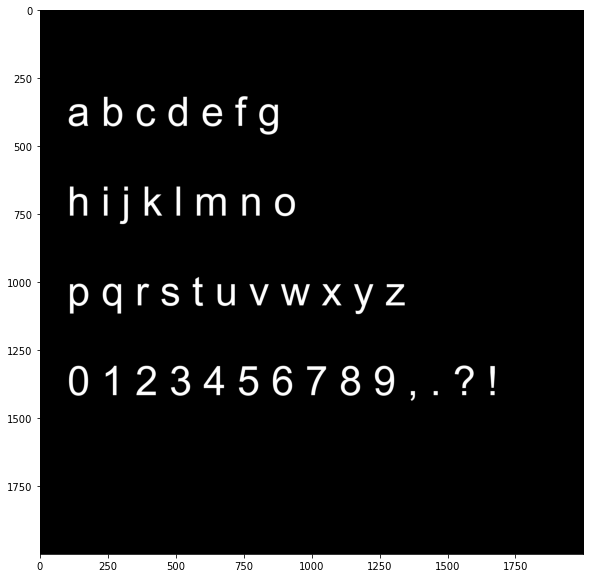

Recognized text: 
a b c d e f g 
l i j l l m n o 
p q r s t u v w x y z 
0 1 2 3 l4 5 6 7 8 9 , . ? ! 

Number of characters occurrences: 
{'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 0, 'i': 1, 'j': 1, 'k': 0, 'l': 4, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1, '0': 1, '1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': 1, '7': 1, '8': 1, '9': 1, '.': 1, ',': 1, '?': 1, '!': 1}


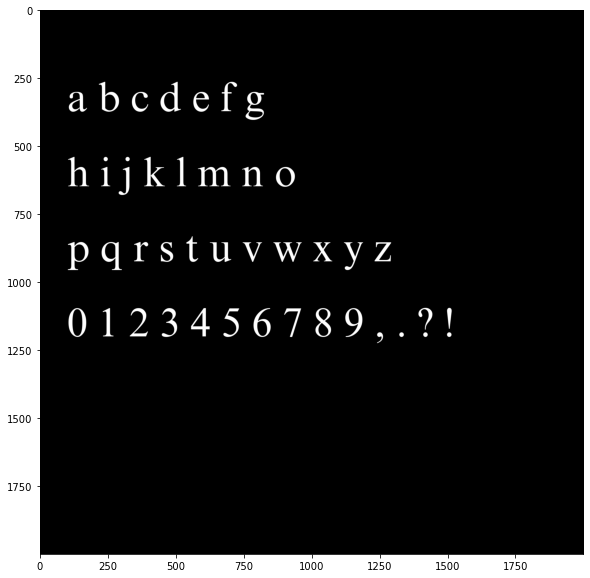

Recognized text: 
a b c d e f g 
h i j k l m n o 
p q r s t u v w x y z 
0 1 2 3 4 5 6 7 8 9 , . ? ! 

Number of characters occurrences: 
{'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1, '0': 1, '1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': 1, '7': 1, '8': 1, '9': 1, '.': 1, ',': 1, '?': 1, '!': 1}


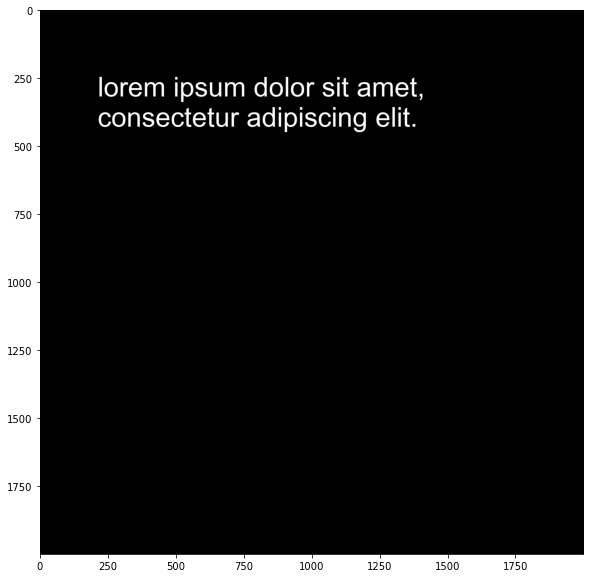

Recognized text: 
lorem ipsum dolor sit amet, 
consectetur a,cipiscing elit. 

Number of characters occurrences: 
{'a': 2, 'b': 0, 'c': 4, 'd': 1, 'e': 5, 'f': 0, 'g': 1, 'h': 0, 'i': 6, 'j': 0, 'k': 0, 'l': 3, 'm': 3, 'n': 2, 'o': 4, 'p': 2, 'q': 0, 'r': 3, 's': 4, 't': 5, 'u': 2, 'v': 0, 'w': 0, 'x': 0, 'y': 0, 'z': 0, '0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '.': 1, ',': 2, '?': 0, '!': 0}


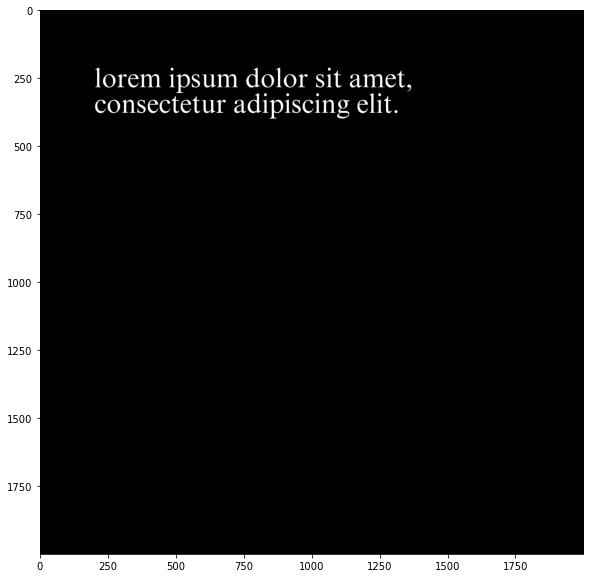

Recognized text: 
lorem ipsum dolor sit amet, 
consectetur adipiscing elit. 

Number of characters occurrences: 
{'a': 2, 'b': 0, 'c': 3, 'd': 2, 'e': 5, 'f': 0, 'g': 1, 'h': 0, 'i': 6, 'j': 0, 'k': 0, 'l': 3, 'm': 3, 'n': 2, 'o': 4, 'p': 2, 'q': 0, 'r': 3, 's': 4, 't': 5, 'u': 2, 'v': 0, 'w': 0, 'x': 0, 'y': 0, 'z': 0, '0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '.': 1, ',': 1, '?': 0, '!': 0}


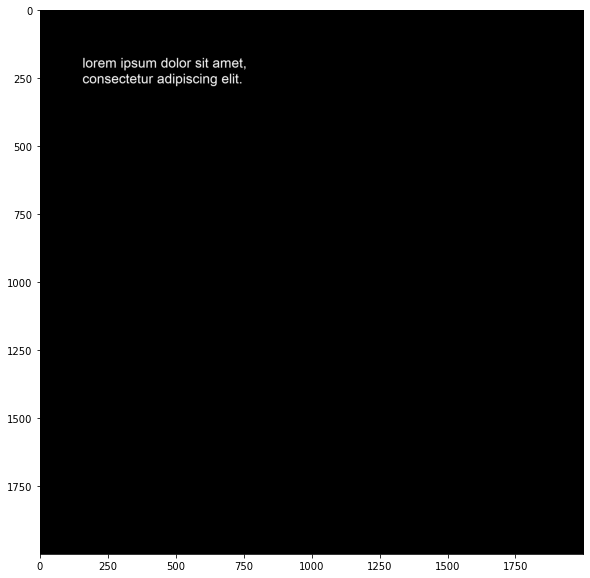

Recognized text: 
lorer ilpsur dolor sit aretl 
consectetur adilpiscing elitl 

Number of characters occurrences: 
{'a': 2, 'b': 0, 'c': 3, 'd': 2, 'e': 5, 'f': 0, 'g': 1, 'h': 0, 'i': 6, 'j': 0, 'k': 0, 'l': 7, 'm': 0, 'n': 2, 'o': 4, 'p': 2, 'q': 0, 'r': 6, 's': 4, 't': 5, 'u': 2, 'v': 0, 'w': 0, 'x': 0, 'y': 0, 'z': 0, '0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '.': 0, ',': 0, '?': 0, '!': 0}


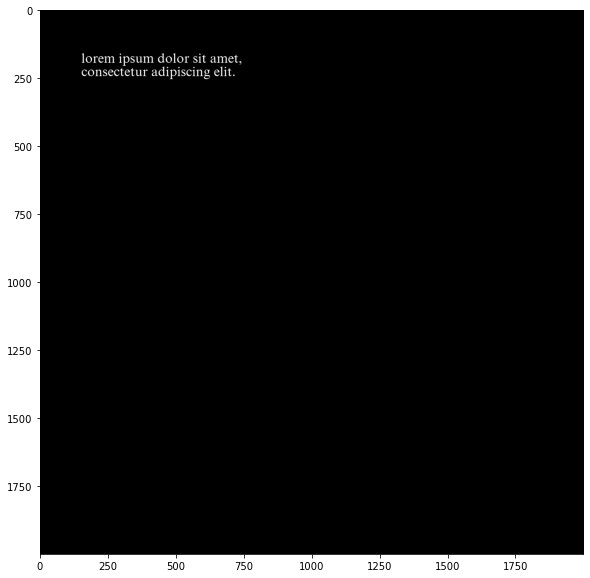

Recognized text: 
lorem ilsum c!olor sit amet, 
consectetur a.!ipiscing elit. 

Number of characters occurrences: 
{'a': 2, 'b': 0, 'c': 4, 'd': 0, 'e': 5, 'f': 0, 'g': 1, 'h': 0, 'i': 6, 'j': 0, 'k': 0, 'l': 4, 'm': 3, 'n': 2, 'o': 4, 'p': 1, 'q': 0, 'r': 3, 's': 4, 't': 5, 'u': 2, 'v': 0, 'w': 0, 'x': 0, 'y': 0, 'z': 0, '0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '.': 2, ',': 1, '?': 0, '!': 2}


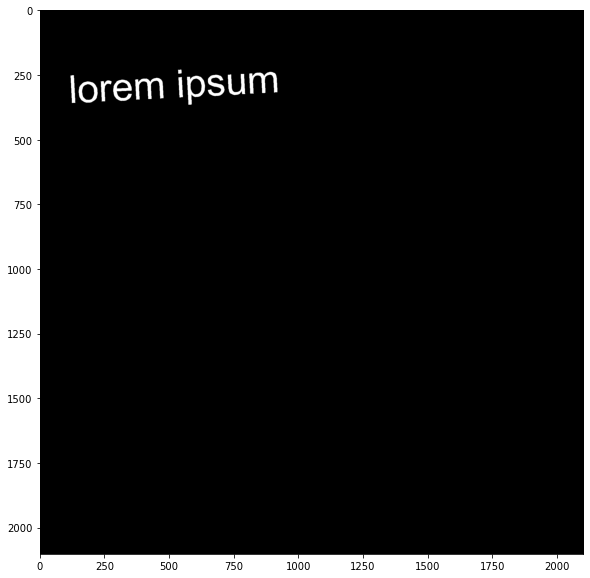

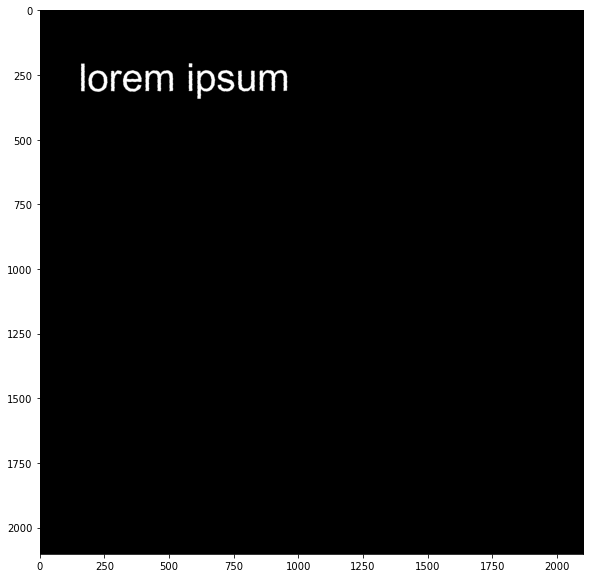

Recognized text: 
lorer, lpsur 

Number of characters occurrences: 
{'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 1, 'f': 0, 'g': 0, 'h': 0, 'i': 0, 'j': 0, 'k': 0, 'l': 2, 'm': 0, 'n': 0, 'o': 1, 'p': 1, 'q': 0, 'r': 3, 's': 1, 't': 0, 'u': 1, 'v': 0, 'w': 0, 'x': 0, 'y': 0, 'z': 0, '0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '.': 0, ',': 1, '?': 0, '!': 0}


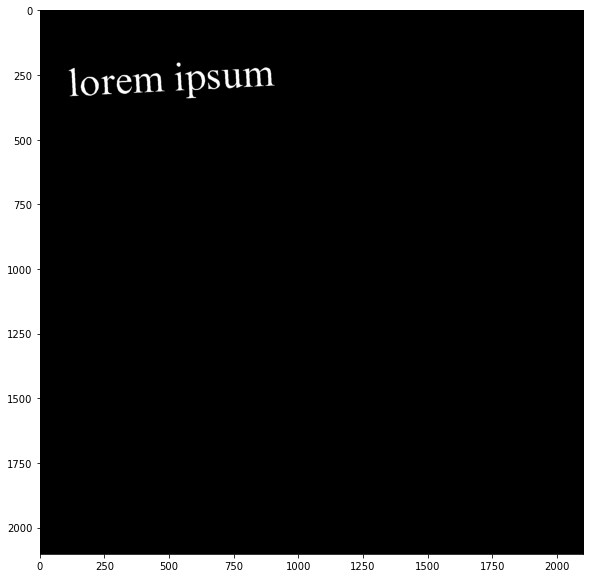

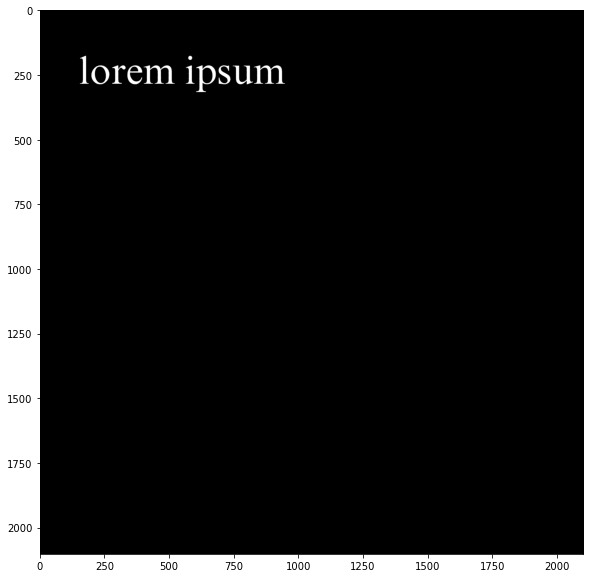

Recognized text: 
lorem ipsum 

Number of characters occurrences: 
{'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 1, 'f': 0, 'g': 0, 'h': 0, 'i': 1, 'j': 0, 'k': 0, 'l': 1, 'm': 2, 'n': 0, 'o': 1, 'p': 1, 'q': 0, 'r': 1, 's': 1, 't': 0, 'u': 1, 'v': 0, 'w': 0, 'x': 0, 'y': 0, 'z': 0, '0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '.': 0, ',': 0, '?': 0, '!': 0}


In [12]:
all_letters_matrix = []

images = [('img1.png', 'Arial.ttf', 150), ('img2.png', 'times_new_roman.ttf', 150), ('img3.png', 'Arial.ttf', 100), ('img4.png', 'times_new_roman.ttf', 100), ('img5.png', 'Arial.ttf', 50), ('img6.png', 'times_new_roman.ttf', 50), ('img7.png', 'Arial.ttf', 150), ('img8.png', 'times_new_roman.ttf', 150)]


for img in images:
    all_letters_matrix.clear()
    
    image_matrix = get_image_from_file(img[0])

    res = ocr(image_matrix, img[2], img[1])

    print("Recognized text: ")
    print(res[0])

    print("Number of characters occurrences: ")
    print(res[1])

W obrazie wejścowym najpierw wyszukiwane są linie, następnie słowa i poszczególne litery. Do każdej wykrytej litery dopasowywany jest wzorzec przy pomocy korelacji. Rozwiązanie to pozwala w łatwiejszy sposób wykryć właściwy wzorzec (unikamy w ten zposób sytuacji, kiedy na przykład zamiast znaku 'd' wykrywane są 'c' i 'l' - sytuacje takie są trudne do wykrycia). Dopasowywanie wzorca litera po literze ma większą złożoność, jednak pozwala uzyskać lepsze wyniki.

Tak zaimplementowane rozpoznawanie znaków działa skuterzenie przy wysokiej rozdzielczości obrazu.
Zauważono, że dla czcionki szeryfowej poszczególne znaki rozpoznawane są z większą skutecznością niż dla czcionki bezszeryfowej.
Zauważono także, że aby uzyskać jak najlepszy wynik należy uwzględnić istotność danego znaku (zmniejszyć istotność takich znaków jak '.', ',' czy 'i', które łatwo mogą być rozpoznane jako część innego znaku).